In [1]:
# A script for me to explain the correlation between thermo and kinetics to myself

## (Some) reaction rates depend on species thermo

$k=AT^be^{-E_a/RT}$

For BEP relations, $E_a$ is a function of the enthalpy of reaction, which depends on species enthalpies

$E_a$ = $E_a(\Delta H_{rxn}) = E_0 + \alpha \Delta H_{rxn} = E_0 + \alpha \sum_i {\nu_i} H_{i}$

Where ${\nu_i}$ is the stoichiometric coefficient and $H_{i}$ is the enthalpy for species $i$.

We can rewrite this as a sum using properties of logs

$\ln k=\ln A +b\ln T - \frac{E_0}{RT} - \alpha \frac{\sum_i {\nu_i} H_{i}}{RT}$

# Each term is an independent source of uncertainty

(This isn't entirely accurate because species calculated using the same DFT method will have correlated/systematic errors, but it's the best we can do without digging into the details of
the BEEF-vdW results. Also, if the reactions are part of the same family, the $E_0$s are probably also correlated.)

We assume each term is independent of the others: $A, b, E_0, H_i$

(Assuming here that $\alpha$ isn't uncertain)

So, if we have two reactions:

$$\ln k_1=\ln A_1 +b_1\ln T - \frac{E_{0,1}}{RT} - \alpha_1 \frac{\sum_i {\nu_i} H_{i}}{RT}$$

$$\ln k_2=\ln A_2 +b_2\ln T - \frac{E_{0,2}}{RT} - \alpha_2 \frac{\sum_i {\nu_i} H_{i}}{RT}$$

and want to know the covariance between them $cov(\ln k_1, \ln k_2)$

The assumptions of independence mean that the only the $\alpha_1 \frac{{\nu_i} H_{i}}{RT}$ terms will be nonzero, and only when the same species appears in both reactions.

# Let's look at an example in RMG

In [9]:
import os
import numpy as np
import rmgpy.data.thermo
import matplotlib.pyplot as plt
%matplotlib inline

### Load the database

In [10]:
# Load the database
database = rmgpy.data.rmg.RMGDatabase()
database.load(
    path = rmgpy.settings['database.directory'],
    thermo_libraries = ['surfaceThermoPt111', 'primaryThermoLibrary'],
    reaction_libraries = ['Surface/CPOX_Pt/Deutschmann2006_adjusted'],
    kinetics_families = ['Surface_Abstraction'],
    kinetics_depositories = ['training'],
    depository = True,
)

### Define/display our example reactions

Reaction 1: CH2X + HOX <=> CH3X + OX

Reaction 2: CHX + HOX <=> CH2X + OX


Reaction 1:


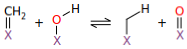


Reaction 2:


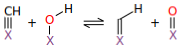


Reaction 3:


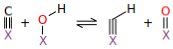


Reaction 4:


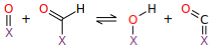

In [41]:
family = 'Surface_Abstraction'
training_depository = database.kinetics.families[family].get_training_depository()
my_reactions = []
for i, entry in enumerate(training_depository.entries):
    print(f'Reaction {i + 1}:')
    display(training_depository.entries[entry].item)
    my_reactions.append(training_depository.entries[entry].item)
    print()

### Look up the BEP kinetics corresponding to each reaction

Note that the training reactions themselves have regular Arrhenius kinetics.
We need to use RMG's kinetics decision tree to get the BEP version.

In [45]:
# Get the kinetics from the RMG family's decision tree
for i, rxn in enumerate(my_reactions):
    print(f'Reaction {i + 1}:')
    
    template_labels = database.kinetics.families[family].get_reaction_template_labels(rxn)
    template = database.kinetics.families[family].retrieve_template(template_labels)
    kinetics = database.kinetics.families[family].get_kinetics_for_template(template, degeneracy=rxn.degeneracy)[0]
    my_reactions[i].kinetics = kinetics
    print(kinetics)
    print()

Reaction 1:
SurfaceArrheniusBEP(A=(4.18e+17,'m^2/(mol*s)'), n=0, alpha=0.37, E0=(99.3,'kJ/mol'), Tmin=(200,'K'), Tmax=(3000,'K'), comment="""Estimated using template [Abstracting;*R-H] for rate rule [C=*;*OH]
Euclidian distance = 2.23606797749979
family: Surface_Abstraction""")

Reaction 2:
SurfaceArrheniusBEP(A=(4.18e+17,'m^2/(mol*s)'), n=0, alpha=0.37, E0=(99.3,'kJ/mol'), Tmin=(200,'K'), Tmax=(3000,'K'), comment="""Estimated using template [Abstracting;*R-H] for rate rule [C#*;*OH]
Euclidian distance = 2.23606797749979
family: Surface_Abstraction""")

Reaction 3:
SurfaceArrheniusBEP(A=(4.18e+17,'m^2/(mol*s)'), n=0, alpha=0.37, E0=(99.3,'kJ/mol'), Tmin=(200,'K'), Tmax=(3000,'K'), comment="""Estimated using template [Abstracting;*R-H] for rate rule [C$*;*OH]
Euclidian distance = 2.23606797749979
family: Surface_Abstraction""")

Reaction 4:
SurfaceArrheniusBEP(A=(4.18e+17,'m^2/(mol*s)'), n=0, alpha=0.94, E0=(129.3,'kJ/mol'), Tmin=(200,'K'), Tmax=(3000,'K'), comment="""Estimated using te

Note that 3/4 of the examples have identical BEP parameters, but will have different $\ln k$
because of the dependence on $\Delta H_{rxn}$

### Grab the species thermo from the database so we can calculate $\Delta H_{rxn}$

In [56]:
lib = database.thermo.libraries['surfaceThermoPt111']
for i, rxn in enumerate(my_reactions):
    for j in range(len(rxn.reactants)):
        my_reactions[i].reactants[j].thermo = database.thermo.get_thermo_data_from_library(
            my_reactions[i].reactants[j],
            lib
        )[0]
    for j in range(len(rxn.products)):
        my_reactions[i].products[j].thermo = database.thermo.get_thermo_data_from_library(
            my_reactions[i].products[j],
            lib
        )[0]

In [47]:
my_reactions[0].reactants[0].thermo

# Plot the kinetics for comparison

In [34]:
def plot_kinetics(rxns, labels=None):
    """Function for plotting reaction kinetics
    Takes in a list of RMG reactions (rmgpy.reaction.Reaction) or a single reaction
    """
    plt.xlabel('1000 / T (K^-1)')
    plt.ylabel('log(k)')

    if type(rxns) != list:
        rxns = [rxns]

    T = np.linspace(300, 3000, 1001)
    for rxn in rxns:
        k = np.zeros(len(T))
        for i in range(0, len(T)):
            k[i] = rxn.get_rate_coefficient(T[i], 101325)
        plt.plot(1000.0 / T, np.log10(k))

    if labels:
        plt.legend(labels)
    plt.show()

In [ ]:
database.kinetics.families['Surface_Abstraction']

In [20]:
type(training_depository.entries[24].data)

rmgpy.kinetics.surface.SurfaceArrhenius

In [5]:
train = database.kinetics.families['Surface_Abstraction'].get_training_depository()

In [11]:
str(train.entries[24].item)

'CH2X_1 + HOX_3 <=> CH3X_4 + OX_5'

In [12]:
str(train.entries[26].item)

'CHX_1 + HOX_3 <=> CH2X_4 + OX_5'

In [ ]:
train.entries[28].item

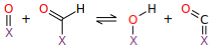

In [15]:
train.entries[39].item

In [ ]:
train.entries

In [ ]:
train.entries[39].item.reactants[0]

In [ ]:
print(train.entries[39].item.reactants[0].to_adjacency_list())

In [ ]:
train.entries[24].item.products[1]

In [ ]:
print(train.entries[24].item.products[1].to_adjacency_list())